## Perform A/B tests to compare the performance between the Troy and Sparta Recommenders:
 to compare the performance of the Troy and Sparta system, propose framework to perform the tests using both the Frequentist and Bayesian methods.
Starting with the Frequentist approach we follow the below steps.

## Business Problem:
 We are trying to compare the effectiveness of the BERT based recommender(Troy system) vs the Hybrid Content (TFIDF) Based recommender (Sparta system).

For the purpose of the experiment the control group will be the Sparta System and treatment group will be the Troy system.

## North Star metric (NSM) -
The number of feedback ratings that are >=4 stars out of 5.

## State the Hypothesis

**Ho:** The NSM for the Troy and Sparta systems are the same .<br>
**Ha:** The NSM for the Troy and Sparta systems are different.

In [ ]:
#import required libraries
from datetime import datetime
import random
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

# Set seed for np random
SEED = 123
np.random.seed(SEED)

## Experiment parameters
alpha = 0.05 # Set the probability threshold at 0.05, if the p-value is less than 0.05, reject Ho.
power = 0.80 # Setting statistical power to 80%. In other words we need to ensure there is a 80% chance of detecting an effect with significance
mde = 0.10   # Detect there is a 10% improvement in using the treatment group as compared to the control group

# Setting the proportions:
# For instance based on some initial testing and the values from the live feedback tracker
# if we determine that the sparta model is 40% effective we can set p1 to 0.4 and
# run our experiment such that we expect a 10% lift on our treatment model i.e 44%

p1 = 0.40 # Control (Sparta)
p2 = p1 * (1+mde) # Treatment (Troy)

### Design the Experiment (Frequentist)
We need to determine the randomization unit, calculating the sample size and determining the experiment duration.

Cohen's D value is an indication of the number of standard deviations between two groups.

For Proportions (Categorical Data):

The formula for Cohen's d when comparing two proportions (p1 and p2) is as follows:

    Cohen's d = 2 * arcsin(√p1) - 2 * arcsin(√p2)

* p1 and p2 are the proportions of the two groups.

The formula for calculating the sample size required for a two-sample independent (unpaired) t-test with two proportions (e.g., in the context of comparing proportions in two groups) can be determined using the following formula:

    n= 2⋅(Z1−α2+Z1−β)^2⋅p(1−p)(p1−p2)/ (p1-p2)^2


Where:

* n is the required sample size per group (control and treatment).
* Z1−α2Z1−2α​​ is the critical value for a two-tailed test at significance level αα. You can find this value from standard normal distribution tables or calculators (e.g., Z1−α2Z1−2α​​ for a 95% confidence interval corresponds to 1.96).
* Z1−βZ1−β​ is the critical value for the desired statistical power (ββ). You can find this value based on your desired power, often denoted as 1−β1−β. Common choices include 0.80, 0.90, etc. This value can be obtained from a standard normal distribution table or calculator.
* pp is the pooled proportion, which can be calculated as (p1⋅n1+p2⋅n2)/(n1+n2)(p1​⋅n1​+p2​⋅n2​)/(n1​+n2​), where n1n1​ and n2n2​ are the sample sizes for the control and treatment groups, and p1p1​ and p2p2​ are the proportions of interest for those groups.
* (p1−p2)(p1​−p2​) is the effect size you want to detect (the difference in proportions you expect to observe in the two groups).

In [ ]:
##Calculating the effect size using Cohen's D
## p1 and p2 can be of different sizes
cohen_D = sm.stats.proportion_effectsize(p1,p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from sparta model at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}, since there are two groups via control and treatment')


To detect an effect of 10.0% lift from sparta model at 40%, the sample size per group required is 2000.
The total sample required in the experiment is 4000, since there are two groups via control and treatment


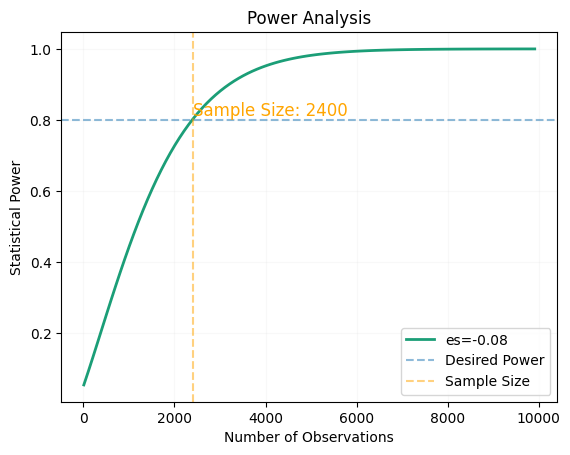

In [ ]:
# Explore power across sample sizes

ttest_power = TTestIndPower() # Statistical Power calculations for t-test for two independent sample, using pooled variance

ttest_power.plot_power(dep_var='nobs', nobs=np.arange(10,10000,100), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(2400, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.text(2400, 0.8, 'Sample Size: 2400', fontsize=12, color='orange', verticalalignment='bottom')
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

While the sample calculation from the two sampled proportion t-test provided us the sample size of 2000, looking at the power analysis we can see that 2400 would be a better choice as this is our intercept from the power analysis. Which means we would require a total of 4800 samples, for both the control and treatment groups.

In [ ]:
#using a 5% mde
mde = 0.05

p1 = 0.40 # Control (Sparta)
p2 = p1 * (1+mde) # Treatment (Troy)

cohen_D = sm.stats.proportion_effectsize(p1,p2)

n = tt_ind_solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from sparta model at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}, since there are two groups via control and treatment')

To detect an effect of 5.0% lift from sparta model at 40%, the sample size per group required is 9000.
The total sample required in the experiment is 18000, since there are two groups via control and treatment


We can see that when we lower the minimum detectable effect we are required a lot more samples. A small MDE can lead to less precise estimates and reduced ability to detect smaller effects. In such a situation it would be helpful to perform a power analysis with different MDE values to see how they impact the required sample size and statistical power. This analysis can inform our decision about the appropriate MDE for the A/B test.

### Estimating the duration of the Experiment

Suppose in a production environment we know what was the number of visits per day, we are trying to estimate the duration required to achieve the required sample size (4800) given the percentage of unique visitors assigned to both control groups.

Accounting for the days of the week effect, typically, we can run the experiment between 7 - 14 days. Since experimentation is designed to be iterative, hence needs to be tested quickly to optimize a product, its better not to extend it beyond 14 days.

Here visits_mean is the average number of unique visitors per day.

In [ ]:
alloc = np.arange(0.10,1.1,0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2*n / size)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('% Traffic Allocated to the Experiment per Day')
plt.show()

### Validity Threats for the A/B test

We will perform an AA test and a chi-square test for sample ratio mismatch (SRM).

Conducting checks for the experiment ensures that the AB test results are trustworthy and reduces risk of committing type 1 and type 2 errors.

We run an AA test to ensure that there is no underlying difference between the control and treatment to begin with. AA test is still important to be performed prior to performing a Bayesian A/B test to validate the robustness of the Bayesian test and identify biases if any.



In [ ]:
!pip install psycopg2 -q

In [ ]:
import psycopg2

# Define the ElephantSQL database URL
database_url = "your_database_url"

# Connect to the database using the database URL
conn = psycopg2.connect(database_url)

# Create a cursor
cur = conn.cursor()

# Define your SQL query
sql_query = "SELECT * FROM feedback_trackersparta"

# Execute the SQL query
cur.execute(sql_query)

# Fetch the data into a Pandas DataFrame
data = cur.fetchall()
df1 = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

sql_query = "SELECT * FROM feedback_trackertroy"

# Execute the SQL query
cur.execute(sql_query)
data = cur.fetchall()

df2 = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

# Close the cursor and the database connection
cur.close()
conn.close()

In [ ]:
#sparta
df1

,id,period,ratings
0,3,June_2023,3
1,8,June_2023,4
2,9,June_2023,4
3,11,October_2023,4
4,12,October_2023,3
5,13,October_2023,3
6,14,October_2023,3


In [ ]:
#troy
df2

,id,period,ratings
0,1,June_2023,5
1,2,June_2023,4
2,5,October_2023,5
3,6,October_2023,4
4,7,October_2023,5
5,8,October_2023,3


In [ ]:
#Grab the control and treatment groups in the AA test
AA_control = df1['ratings']
AA_treatment = df2['ratings']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'Control Rate: {AA_control_rate:.3}') # round to 2 decimal places
print(f'Treatment  Rate: {AA_treatment_rate:.3}')

-------- AA Test ----------
Control Rate: 3.43
Treatment  Rate: 4.33


In [ ]:
# Run a chi-square test

# Execute test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])


# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print('Ho: The distribution of user ratings between control and treatment groups are same.')
print('Ha: The distribution of user ratings between control and treatment groups are different.\n')
print(f'Significance level: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

Ho: The distribution of user ratings between control and treatment groups are same.
Ha: The distribution of user ratings between control and treatment groups are different.

Significance level: 0.05
Chi-Square = -0.242 | P-value = 1.000

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


###  Running the Experiment

We proceed with running the experiment and gathering the 4800 samples required to perform the A/B test.
In the following code we calculate the lift% followed by validitating if there is any satitstical significance in the lift %.

In [ ]:
#Grab the control and treatment groups in the AA test
AB_control = df1['ratings']
AB_treatment = df2['ratings']

# Get stats
AB_control_cnt = AB_control.sum()
AB_treatment_cnt = AB_treatment.sum()
AB_control_rate = AB_control.mean()
AB_treatment_rate = AB_treatment.mean()
AB_control_size = AB_control.count()
AB_treatment_size = AB_treatment.count()

# Show calculation
print('-------- AB Test ----------')
print(f'Control Rate: {AB_control_rate:.3}') # round to 2 decimal places
print(f'Treatment  Rate: {AB_treatment_rate:.3}')

In [ ]:
Lift = ((AB_treatment_rate - AB_control_rate)/ AB_control_rate ) * 100

#### Conduct Statistical Inference:

We will now perform a Chi-Squared evaluate the results from the experiment and conclude if there is any statical significance in the observed results:

Hypothesis:

'Ho: The observed Lift % is by chance and there is no significant difference between the Sparta and Troy systems.

'Ha: The Lift % observed is significant and there is a definte difference between the Sparta and Troy systems.

Note: we can also use a t-test as another viable test.






In [ ]:
#Inference:
# Let's start with the chi-squared test

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

AB_ALPHA = 0.05

# Run results
print('Ho: The observed Lift % is by chance and there is no significant difference between the \
            ratings for the Sparta and Troy systems..')
print('Ha: The Lift % observed is significant and there is a definte difference between the user \
            ratings for the Sparta and Troy systems..\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference in performance between \
              the Sparta and Troy systems .')
else:
  print('Fail to reject Ho.')

# Bayesian A/B Test Approach

For this analysis we take into account the average Beta(success, failure) distribution for both the models.

Looking at the live feedback tracker and taking into account our NSM which was the number of users that give a rating of >=4 out of 5 stars, we see that for both the models across there are total of 13 ratings with 8 ratings being >=4 and 5 less than 4, here the success rate is 8 and failure rate is 5. We will take this beta(8,5)into conisderation.

We know from initial testing that we have done so far the true success rate is ~40% for the Sparta Model and ~83% for troy model.


A = Troy
B = Sparta


Assuming a group_size of 1000 samples we will calculate the posterior probabilities using the beta distribution, perform a monte carlo simulation for 100000 randomly distributed posterior probabilities for both A and B and then compare the A win rate which the percentage of times the probabilities of A beats B.

In [ ]:
import numpy as np
np.random.seed(42)
from scipy.stats import beta

group_size = 10000
A_group, B_group = np.random.rand(2,group_size)

#so take a prior of 1,1
group_size = 10000
A_successes = sum(A_group<0.83)
B_successes = sum(B_group<0.42)

A_failures = group_size - A_successes
B_failures = group_size - B_successes

A_posterior = beta(A_successes + 8, A_failures + 5) # non informative beta
B_posterior = beta(B_successes + 8, B_failures+5)

In [ ]:
#monte carlo simulation
import pandas as pd
n_trails = 100000

A_samples = pd.Series([A_posterior.rvs() for _ in range(n_trails)])

B_samples = pd.Series([B_posterior.rvs() for _ in range(n_trails)])

A_wins = sum(A_samples > B_samples)

A_wins/n_trails # percentage of A wins

1.0

Looking at the results from above, we observe a 100% probability that Model A (Troy) outperforms Model B (Sparta) in the recommender system.

While the sample size for this initial analysis is relatively small, we can replicate this framework in a real production environment, adhering to the experiment's specified duration and ensuring proper randomization across distinct user groups to prevent sample mixing.

The primary advantage of the Bayesian approach, compared to the frequentist approach, is that it doesn't require us to wait until we've collected the 4,800 samples needed for traditional hypothesis testing. This advantage can significantly reduce opportunity costs, allowing us to promptly conduct a Bayesian test when a sufficiently diverse sample becomes available, as demonstrated with this small sample size used in this analysis.

We can repeat the Bayesian experiment by updating our prior beliefs and choosing a beta distribution that can be infered from subject matter experts or results from a production environment experiment and keep updating our posterior probabilities and continously help in making effective comparisons and support our decision to launch one system over the other.


Text(0, 0.5, 'Frequency')

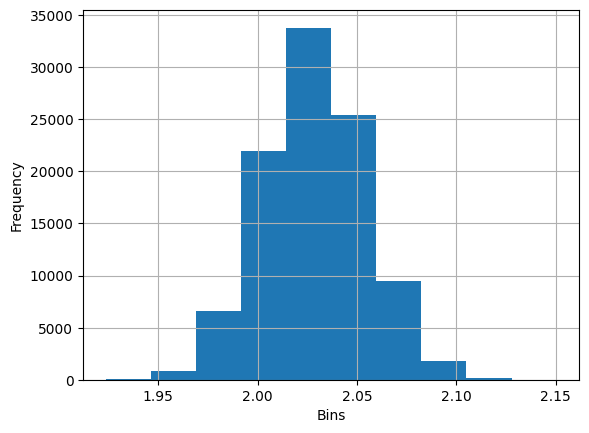

In [ ]:
A_relative = A_samples/ B_samples
A_relative.hist()
plt.xlabel('Bins')
plt.ylabel('Frequency')

We can see that from the Troy system we can expect a 2 - 2.1x improvement over the Sparta system.


Diagram Explaining difference between Frquentist and Bayesian Testing Approach.



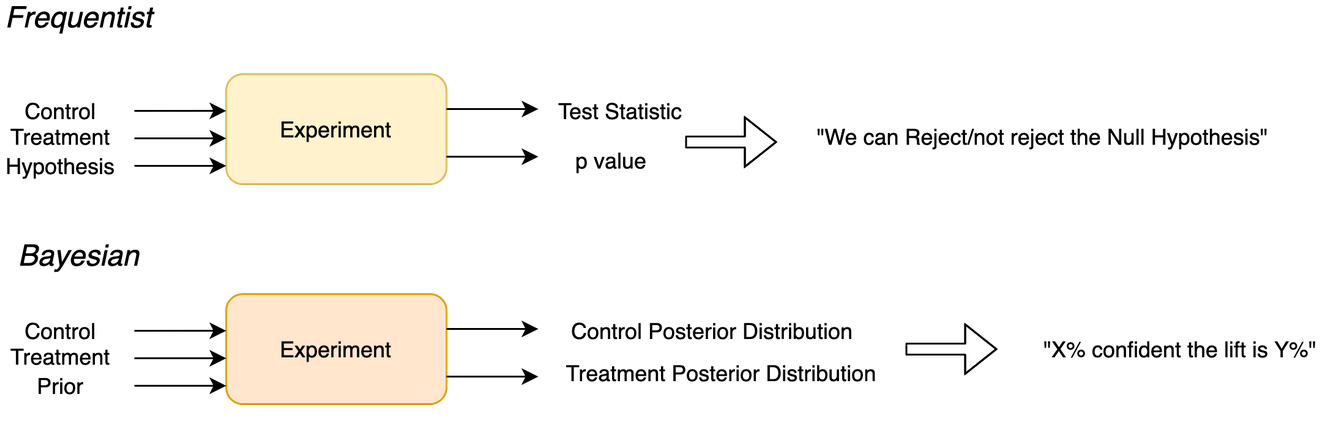

### Validity Threats that need to be considered as part of the Analysis:

* AA test - Execute this test prior to performing the A/B test.
  Ensure that the control and treatment groups are starting in the same condition before the AB test. If the test shows significance in the difference, then theres a potential validity threat such as the instrumentation effect.

  Hypothesis:
  Ho : Two groups are the same.
  Ha : Two groups are different.

  Statistical Tests
  * Chi-Squared Test
  * Two Proportion/Mean tests

  If fail to reject, proceed with the AB test, else need to check randomization, SRM errors, instrumentation errors.

* Stable Unit Treatment Value Assumption (SUTVA): This assumption states that one group's treatment should not interfere with another group in an experiment. To ensure SUTVA, we must segregate users in such a way that they belong to either the treatment or control group, but not both. Additionally, there should be no business relationship between users in the control and treatment groups.

* Survivorship Bias: Survivorship bias occurs when the analysis is based only on the data of participants who completed the test or remained in the experiment. Those who dropped out, churned, or were excluded for some reason are not considered. This can lead to an overestimation of the treatment effect because the experiences of non-survivors are not accounted for.

* Sample Ratio Mismatch (SRM): Ideally, we want the sample split between the control and treatment groups to be 50-50%. However, randomization resulted in a 40-60 split, which may lead to skewed experiment results. We can apply a chi-square goodness-of-fit test or a one-sample z-test for proportion. The hypotheses are as follows:

    Ho: The ratio of samples is 1:1.
    Ha: The ratio of samples is not 1:1.
    If we reject Ho, we conclude that the samples are not 1:1 and need to make changes and re-run the experiment to maintain the sample proportions. Note that Bayesian testing is more robust and has less sensitivity to SRM.

* Primacy Effect: Users often form initial impressions of a website, app, or product based on their first interactions. These first impressions can have a lasting impact on user behavior throughout the test. To mitigate the primacy effect in A/B testing, researchers may use techniques like randomization, counterbalancing, or segmenting to distribute the impact of the order effect evenly across the user population.

* Novelty Effect: The novelty effect is a temporary increase in the Key Performance Indicator (KPI) led by users' initial interest in a new change. However, over time, as users lose interest, the KPI may revert to the norm. The novelty effect increases the Type I error rate (false rejection of Ho). To address this, segment users or run the experiment for a longer duration to gauge the novelty effect.

* Holiday Effect: The holiday effect is a temporary increase in the KPI during holidays when users engage with a product more. This also increases the Type I error rate. To mitigate this effect, avoid running experiments during holidays.


# Deciding Whether to Launch

Frequentist Approach:

In the frequentist approach, we tabulate the percentage lift based on the number of samples and the duration calculated from the steps outlined above. We then conduct a statistical inference using either a chi-square test or a t-test to determine if there is any statistical significance. If we reject the null hypothesis, we can conclude that there is statistical evidence that the Troy system is indeed superior to the Sparta system. This evidence informs our decision to launch the Troy system.

Bayesian Approach:

In the Bayesian approach, we run the experiment while diligently mitigating bias and addressing validity threats. We collect a sufficiently large sample size and leverage prior probabilities derived from the collected data, incorporating the beta distribution based on research conducted on both recommender systems. We compare the posterior probabilities of the Troy system against the Sparta system. If the posterior probabilities for the Troy system convincingly indicate its superiority over the Sparta system, we can make an informed decision to proceed with the launch of the Troy system.